In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

from alg.sparse_quad_pfmpc_vel import SparseQuadPFMPCVel
from alg.sparse_l1_pfmpc_vel import Sparse1NormPFMPCVel
from alg.linear_feedback import LinearFeedback
from dyn.linear_long_vel import LinearLongVel
from utils.iser_leader_traj import accel_decel_step, accel_step, brake_step

# Repeat hardware experiment in simulation

In [2]:
n_trials = 10
H = 100    # planning horizon
N = 10      # N+1 vehicles in platoon, vehicle 0 is virtual leader
dt = 0.1  # timestep
total_time = 25.0  # seconds
total_time += dt * H
d_des = 1.   # desired spacing
da_max = 2.0  # max jerk

# noise properties
dyn_noise = np.array([0.08, 0.08])
sense_noise = np.array([0.08, 0.08])
ranging_std = .045  # std when using pozyx devices
rng = np.random.default_rng()

# dynamics stuff
d_des = 1.
v_min, v_max = -100., 100.
x_min = np.array([-np.inf, v_min])
x_max = np.array([np.inf, v_max])
u_min = np.array([v_min])
u_max = np.array([v_max])
a_max = 5.
taus = [None] + [0.3 for _ in range(N)]
dyns = [None] + [LinearLongVel(dt, x_min, x_max, u_min, u_max, tau) for tau in taus[1:]]
n, m, p = dyns[1].n, dyns[1].m, dyns[1].p

# quad pfmpc algorithm
q_vals = [None, 1] + [1 for _ in range(1, N)]
q_p_vals = [None, 1] + [1 for _ in range(1, N)]
r_vals = [None] + [1 for _ in range(N)]
Q = [None] + [q * np.eye(p) for q in q_vals[1:]]
Q_p = [None] + [q_p * np.eye(p) for q_p in q_p_vals[1:]]
R = [None] + [r * np.eye(m) for r in r_vals[1:]]
quad_pfmpc = [None] + [SparseQuadPFMPCVel(Q[i], Q_p[i], R[i], dyns[i], 
                                          v_min, v_max, a_max, H) 
                       for i in range(1, N+1)]

# l1 pfmpc algorithm
W = np.eye(p)
q_s = [None, 1] + [1 for _ in range(1, N)]
q_p = [None, 1] + [1 for _ in range(1, N)]
r = [None] + [1 for _ in range(N)]
l1_pfmpc = [None] + [Sparse1NormPFMPCVel(W, q_s[i], q_p[i], r[i], dyns[i], 
                                         v_min, v_max, a_max, H)
                     for i in range(1, N+1)]

# linear feedback algorithm
k_p = 1
k_v = 2
k_a = 0
lfbk = [None] + [LinearFeedback(k_p, k_v, k_a) for i in range(1, N+1)]

## Leader trajectory

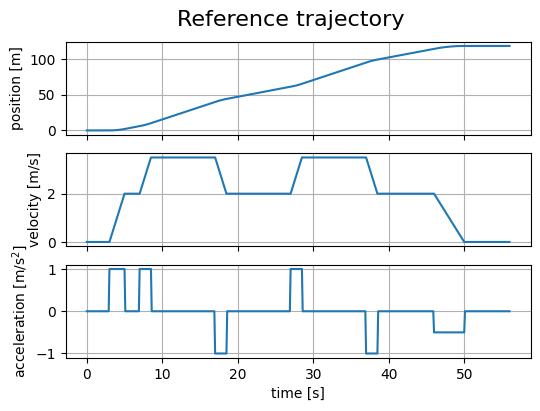

In [3]:
dt = 0.1
zero_time = 3.0
time_0 = np.arange(0, zero_time + dt, dt)
x_ref_0 = np.zeros((3, len(time_0)))

v_low = 2.0
v_high = 3.5
stag_T = 20.
ref_accel = 1.0
init_accel_time = v_low / ref_accel
x_ref_1, time_1 = accel_step(v_low, init_accel_time, dt, init_accel_time + 1, 0.)
x_ref_1 = np.c_[x_ref_0[:, :-1], x_ref_1]
time_1 += time_0[-1]
time_1 = np.concatenate([time_0[:-1], time_1])

accel_time = (v_high - v_low) / ref_accel
repeat_accel_start = 1.
repeat_accel_end = repeat_accel_start + accel_time
repeat_decel_start = stag_T / 2. + 1
repeat_decel_end = repeat_decel_start + accel_time
x_ref_2, time_2 = accel_decel_step(
    stag_T, dt, repeat_accel_start, repeat_accel_end,
    repeat_decel_start, repeat_decel_end, v_low, v_high)
x_ref_2[0, :] += x_ref_1[0, -1]
x_ref_2 = np.c_[x_ref_1[:, :-1], x_ref_2]
time_2 += time_1[-1]
time_2 = np.concatenate([time_1[:-1], time_2])

x_ref_3, time_3 = accel_decel_step(
    stag_T, dt, repeat_accel_start, repeat_accel_end,
    repeat_decel_start, repeat_decel_end, v_low, v_high)
x_ref_3[0, :] += x_ref_2[0, -1]
x_ref_3 = np.c_[x_ref_2[:, :-1], x_ref_3]
time_3 += time_2[-1]
time_3 = np.concatenate([time_2[:-1], time_3])

brake_decel = -0.5
x_ref_4, time_4 = brake_step(brake_decel, dt, stag_T, x_ref_3[1, -1])
x_ref_4[0, :] += x_ref_3[0, -1]
time_4 += time_3[-1]

x_ref = np.c_[x_ref_3[:, :-1], x_ref_4]
y_ref = x_ref[:2, :]
t_range = np.concatenate([time_3[:-1], time_4])

T = len(t_range)
t_range_mpc = t_range[:T-H]

fig, ax = plt.subplots(3, 1, figsize=(6, 4), sharex=True)
fig.suptitle("Reference trajectory", size=16)
fig.subplots_adjust(top=0.9)

for i in range(x_ref.shape[0]):
    ax[i].plot(t_range[:T-H], x_ref[i, :T-H])
    ax[i].grid()
ax[0].set_ylabel("position [m]")
ax[1].set_ylabel("velocity [m/s]")
ax[2].set_ylabel(r"acceleration [m/s$^2$]")
ax[2].set_xlabel("time [s]");

## Leader reference tracking

### Quadratic PFMPC

In [4]:
x_track = np.zeros((n, T-H))
u_track = np.zeros((m, T-H-1))

# initial condition
x_track[:, 0] = x_ref[:2, 0]

# initialized assumed states, controls, and outputs for first timestep
x_a_track = np.zeros((n, H + 1))
u_a_track = np.zeros((m, H))
x_a_track[:, 0] = x_track[:, 0]
u_a_track[0, :] = x_track[1, 0]
for k in range(H):
    x_a_track[:, k+1] = dyns[1].forward(x_a_track[:, k], u_a_track[:, k])

In [5]:
start_time = time.time()
for k in tqdm(range(T - H - 1)):
    x_0 = x_track[:, k]
    x_a = copy.deepcopy(x_a_track)
    x_pred_a = y_ref[:, k:k+H+1]
    d = 0.

    u_opt, x_opt, prob = quad_pfmpc[1].control(x_0, x_a, x_pred_a, d)
    if prob.status != 'optimal':
        print(f"timestep {k}, problem returned: {prob.status}")
        break

    u_track[:, k] = u_opt[:, 0]
    x_track[:, k+1] = dyns[1].forward(x_0, u_opt[:, 0])

    # update assumed state, control, output
    u_a_track[:, :H-1] = u_opt[:, 1:H]
    u_a_track[:, H-1] = u_a_track[:, H-2]
    x_a_track[:, 0] = x_opt[:, 1]
    for t in range(H):
        x_a_track[:, t+1] = dyns[1].forward(x_a_track[:, t], u_a_track[:, t])
    
end_time = time.time()
avg_time = (end_time - start_time) / (T - H)

100%|██████████| 560/560 [00:03<00:00, 146.32it/s]


In [6]:
print(f"quad pfmpc leader track avg rate: {1 / avg_time} Hz")
print("\nproblem data:")
print(f"    scalar variables: {prob.size_metrics.num_scalar_variables}")
print(f"    scalar eq constraints: {prob.size_metrics.num_scalar_eq_constr}")
print(f"    scalar ineq constraints: {prob.size_metrics.num_scalar_leq_constr}")

quad pfmpc leader track avg rate: 146.02169494680894 Hz

problem data:
    scalar variables: 694
    scalar eq constraints: 596
    scalar ineq constraints: 398


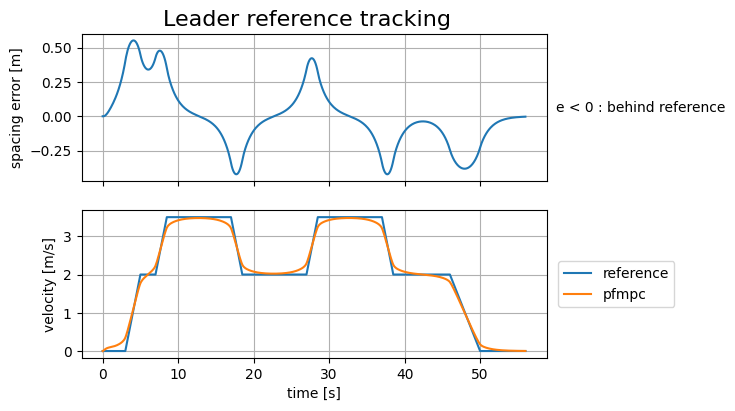

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
fig.suptitle("Leader reference tracking", size=16)
fig.subplots_adjust(top=0.92)

ax[0].plot(t_range[:T-H], x_track[0, :T-H] - x_ref[0, :T-H], label="pf-mpc")
ax[0].text(1.02, 0.5, "e < 0 : behind reference", va='center', 
           transform=ax[0].transAxes)
ax[1].plot(t_range_mpc, x_ref[1, :T-H], label="reference")

ax[1].plot(t_range_mpc, x_track[1, :], label="pfmpc")

ax[0].set_ylabel("spacing error [m]")
ax[1].set_ylabel("velocity [m/s]")
ax[1].set_xlabel("time [s]")
ax[1].legend(bbox_to_anchor=(1.01, 0.5), loc="center left")

for a in ax.flatten():
    a.grid()

### $l_1$ PFMPC

In [8]:
x_track = np.zeros((n, T-H))
u_track = np.zeros((m, T-H-1))

x_track[:, 0] = y_ref[:, 0]

# initialized assumed states, controls, and outputs for first timestep
x_a_track = np.zeros((n, H + 1))
u_a_track = np.zeros((m, H))
x_a_track[:, 0] = x_track[:, 0]
u_a_track[0, :] = x_track[1, 0]
for k in range(H):
    x_a_track[:, k+1] = dyns[1].forward(x_a_track[:, k], u_a_track[:, k])

In [9]:
start_time = time.time()
for k in tqdm(range(T - H - 1)):
    x_0 = x_track[:, k]
    x_a = copy.deepcopy(x_a_track)
    x_pred_a = y_ref[:, k:k+H+1]
    d = 0.

    u_opt, x_opt, prob = l1_pfmpc[1].control(x_0, x_a, x_pred_a, d)
    if prob.status != 'optimal':
        print(f"timestep {k}, problem returned: {prob.status}")
        break

    u_track[:, k] = u_opt[:, 0]
    x_track[:, k+1] = dyns[1].forward(x_0, u_opt[:, 0])

    # update assumed state, control, output
    u_a_track[:, :H-1] = u_opt[:, 1:H]
    u_a_track[:, H-1] = u_a_track[:, H-2]
    x_a_track[:, 0] = x_opt[:, 1]
    for t in range(H):
        x_a_track[:, t+1] = dyns[1].forward(x_a_track[:, t], u_a_track[:, t])
    
end_time = time.time()
avg_time = (end_time - start_time) / (T - H)

100%|██████████| 560/560 [00:05<00:00, 95.05it/s] 


In [10]:
print(f"l1 pfmpc leader track avg rate: {1 / avg_time} Hz")
print("\nproblem data:")
print(f"    scalar variables: {prob.size_metrics.num_scalar_variables}")
print(f"    scalar eq constraints: {prob.size_metrics.num_scalar_eq_constr}")
print(f"    scalar ineq constraints: {prob.size_metrics.num_scalar_leq_constr}")

l1 pfmpc leader track avg rate: 95.19678890077981 Hz

problem data:
    scalar variables: 794
    scalar eq constraints: 200
    scalar ineq constraints: 1392


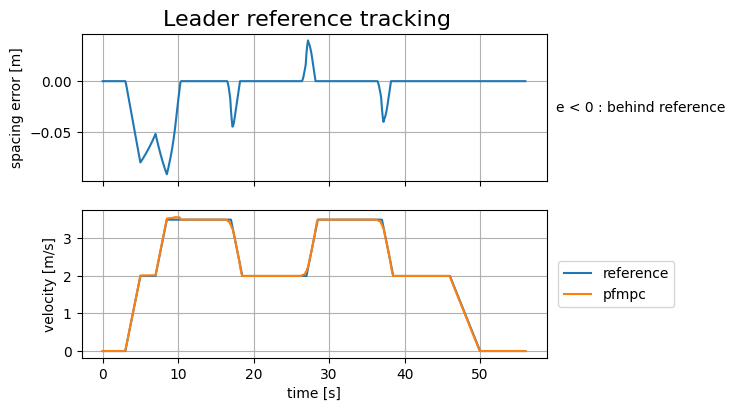

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
fig.suptitle("Leader reference tracking", size=16)
fig.subplots_adjust(top=0.92)

ax[0].plot(t_range[:T-H], x_track[0, :T-H] - x_ref[0, :T-H], label="pf-mpc")
ax[0].text(1.02, 0.5, "e < 0 : behind reference", va='center', 
           transform=ax[0].transAxes)
ax[1].plot(t_range_mpc, x_ref[i-1, :T-H], label="reference")

# ax[0].plot(t_range_mpc, x_track[0, :], label="pf-mpc")
ax[1].plot(t_range_mpc, x_track[1, :], label="pfmpc")

ax[0].set_ylabel("spacing error [m]")
ax[1].set_ylabel("velocity [m/s]")
ax[1].set_xlabel("time [s]")
ax[1].legend(bbox_to_anchor=(1.01, 0.5), loc="center left")

for a in ax.flatten():
    a.grid()

### Linear feedback

In [12]:
x_track = np.zeros((n, T-H))
u_track = np.zeros((m, T-H-1))

# initial condition
x_track[:, 0] = y_ref[:, 0]

In [13]:
start_time = time.time()
for k in tqdm(range(T - H - 1)):
    x_0 = x_track[:, k]
    x_pred = x_ref[:, k]
    d = 0.

    pos_err = x_0[0] - x_pred[0] + d
    vel_err = x_0[1] - x_pred[1]
    accel_err = 0.
    u_opt = x_0[1] + lfbk[1].control(pos_err, vel_err, accel_err)
    u_opt = np.clip(u_opt, x_0[1] - dt*a_max, x_0[1] + dt*a_max)

    u_track[:, k] = u_opt
    x_track[:, k+1] = dyns[1].forward(x_0, np.array([u_opt]))

end_time = time.time()
avg_time = (end_time - start_time) / (T - H)

100%|██████████| 560/560 [00:00<00:00, 55872.17it/s]


In [14]:
print(f"lfbk leader track avg rate: {1 / avg_time} Hz")
print("\nproblem data:")
print(f"    scalar variables: {prob.size_metrics.num_scalar_variables}")
print(f"    scalar eq constraints: {prob.size_metrics.num_scalar_eq_constr}")
print(f"    scalar ineq constraints: {prob.size_metrics.num_scalar_leq_constr}")

lfbk leader track avg rate: 29701.40294362677 Hz

problem data:
    scalar variables: 794
    scalar eq constraints: 200
    scalar ineq constraints: 1392


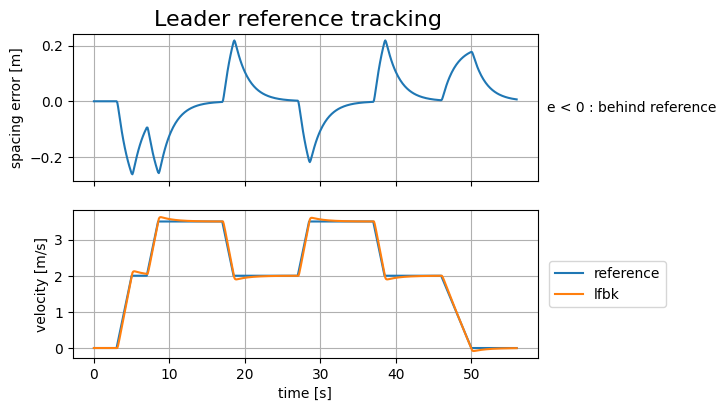

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
fig.suptitle("Leader reference tracking", size=16)
fig.subplots_adjust(top=0.92)

ax[0].plot(t_range[:T-H], x_track[0, :T-H] - x_ref[0, :T-H], label="pf-mpc")
ax[0].text(1.02, 0.5, "e < 0 : behind reference", va='center', 
           transform=ax[0].transAxes)
ax[1].plot(t_range_mpc, x_ref[1, :T-H], label="reference")

# ax[0].plot(t_range_mpc, x_track[0, :], label="pf-mpc")
ax[1].plot(t_range_mpc, x_track[1, :], label="lfbk")

ax[0].set_ylabel("spacing error [m]")
ax[1].set_ylabel("velocity [m/s]")
ax[1].set_xlabel("time [s]")
ax[1].legend(bbox_to_anchor=(1.01, 0.5), loc="center left")

for a in ax.flatten():
    a.grid()

## Platoon experiment - replicate hardware experiment

In [16]:
def init_quad_pfmpc(n, m, N, T, H, dyns, x_ref, d_des):
    x_quad_pfmpc = [np.zeros((n, T-H)) for _ in range(N + 1)]
    u_quad_pfmpc = [np.zeros((m, T-H-1)) for _ in range(N + 1)]

    # zeroth vehicle is virtual leader
    x_quad_pfmpc[0] = x_ref[:n, :T-H]
    u_quad_pfmpc[0][:, :T-H-1] = x_ref[1, :T-H-1]

    # initial condition: start in correct place with desired spacing, velocity, and 
    # acceleration
    for i in range(1, N + 1):
        d = 0 if i == 1 else d_des
        x_quad_pfmpc[i][:, 0] = np.array([-(i-1)*d, x_quad_pfmpc[0][1, 0]])

    # initialize assumed states, controls, and output for first timestep
    x_a_quad_pfmpc = [np.zeros((n, H + 1)) for _ in range(N + 1)]
    x_a_quad_pfmpc[0] = x_quad_pfmpc[0][:, :H+1]
    u_a_quad_pfmpc = [np.zeros((m, H)) for _ in range(N + 1)]
    u_a_quad_pfmpc[0] = u_quad_pfmpc[0][:H]
    for i in range(1, N + 1):
        x_a_quad_pfmpc[i][:, 0] = x_quad_pfmpc[i][:, 0]
        u_a_quad_pfmpc[i][0, :] = x_quad_pfmpc[i][1, 0]

    for i in range(1, N+1):
        for k in range(H):
            x_a_quad_pfmpc[i][:, k+1] = dyns[i].forward(x_a_quad_pfmpc[i][:, k], 
                                                        u_a_quad_pfmpc[i][:, k])

    return x_quad_pfmpc, u_quad_pfmpc, x_a_quad_pfmpc, u_a_quad_pfmpc

In [17]:
def init_l1_pfmpc(n, m, N, T, H, dyns, x_ref, d_des):
    x_l1_pfmpc = [np.zeros((n, T-H)) for _ in range(N + 1)]
    u_l1_pfmpc = [np.zeros((m, T-H-1)) for _ in range(N + 1)]

    # zeroth vehicle is virtual leader
    x_l1_pfmpc[0] = x_ref[:n, :T-H]
    u_l1_pfmpc[0][:, :T-H-1] = x_ref[1, :T-H-1]

    # initial condition: start in correct place with desired spacing, velocity, and 
    # acceleration
    for i in range(1, N + 1):
        d = 0 if i == 1 else d_des
        x_l1_pfmpc[i][:, 0] = np.array([-(i-1)*d, x_l1_pfmpc[0][1, 0]])

    # initialize assumed states, controls, and output for first timestep
    x_a_l1_pfmpc = [np.zeros((n, H + 1)) for _ in range(N + 1)]
    x_a_l1_pfmpc[0] = x_l1_pfmpc[0][:, :H+1]
    u_a_l1_pfmpc = [np.zeros((m, H)) for _ in range(N + 1)]
    u_a_l1_pfmpc[0] = u_l1_pfmpc[0][:H]
    for i in range(1, N + 1):
        x_a_l1_pfmpc[i][:, 0] = x_l1_pfmpc[i][:, 0]
        u_a_l1_pfmpc[i][0, :] = x_l1_pfmpc[i][1, 0]

    for i in range(1, N+1):
        for k in range(H):
            x_a_l1_pfmpc[i][:, k+1] = dyns[i].forward(x_a_l1_pfmpc[i][:, k], 
                                                      u_a_l1_pfmpc[i][:, k])

    return x_l1_pfmpc, u_l1_pfmpc, x_a_l1_pfmpc, u_a_l1_pfmpc

In [18]:
def init_lfbk(n, m, N, T, H, d_des):
    x_lfbk = [np.zeros((n, T-H)) for _ in range(N + 1)]
    u_lfbk = [np.zeros((m, T-H-1)) for _ in range(N + 1)]

    # zeroth vehicle is virtual leader
    x_lfbk[0] = x_ref[:n, :T-H]
    u_lfbk[0][:, :T-H-1] = x_ref[1, :T-H-1]

    # initial condition: start in correct place with desired spacing, velocity, and 
    # acceleration
    for i in range(1, N + 1):
        d = 0 if i == 1 else d_des
        x_lfbk[i][:, 0] = np.array([-(i-1)*d, x_lfbk[0][1, 0]])
    
    return x_lfbk, u_lfbk

In [19]:
# list of lists to hold vel rms errors, each inner list corresponds to a vehicle, 
# each element of inner list is vehicle's errors during that trial
quad_pfmpc_dist_errors = [[] for _ in range(N+1)]
quad_pfmpc_vel_errors = [[] for _ in range(N+1)]
l1_pfmpc_dist_errors = [[] for _ in range(N+1)]
l1_pfmpc_vel_errors = [[] for _ in range(N+1)]
lfbk_dist_errors = [[] for _ in range(N+1)]
lfbk_vel_errors = [[] for _ in range(N+1)]

# also store trajectory data from trials
quad_pfmpc_x_trajs = []
quad_pfmpc_u_trajs = []
l1_pfmpc_x_trajs = []
l1_pfmpc_u_trajs = []
lfbk_x_trajs = []
lfbk_u_trajs = []

In [20]:
no_soln = False
for _ in tqdm(range(n_trials)):

    x_quad_pfmpc, u_quad_pfmpc, x_a_quad_pfmpc, u_a_quad_pfmpc = \
        init_quad_pfmpc(n, m, N, T, H, dyns, x_ref, d_des)
    x_a_quad_pfmpc_prev = copy.deepcopy(x_a_quad_pfmpc)
    u_a_quad_pfmpc_prev = copy.deepcopy(u_a_quad_pfmpc)

    x_l1_pfmpc, u_l1_pfmpc, x_a_l1_pfmpc, u_a_l1_pfmpc = \
        init_l1_pfmpc(n, m, N, T, H, dyns, x_ref, d_des)
    x_a_l1_pfmpc_prev = copy.deepcopy(x_a_l1_pfmpc)
    u_a_l1_pfmpc_prev = copy.deepcopy(u_a_l1_pfmpc)

    x_lfbk, u_lfbk = init_lfbk(n, m, N, T, H, d_des)

    for k in range(T - H - 1):
        for i in range(1, N+1):
            v = rng.normal(0, dyn_noise)
            w = rng.normal(0, sense_noise)
            dist_noise = rng.normal(0, ranging_std)

            # quad pfmpc
            x_0 = x_quad_pfmpc[i][:, k] + v
            x_a = x_a_quad_pfmpc_prev[i]
            x_pred_a = x_a_quad_pfmpc_prev[i-1]
            if i > 1:
                dist = x_quad_pfmpc[i-1][0, k] - x_quad_pfmpc[i][0, k] + dist_noise
                x_pred_a[0, :] -= x_pred_a[0, 0]
                x_pred_a[0, :] += x_0[0]
                x_pred_a[0, :] += dist
            d = 0 if i == 1 else d_des

            u_opt, x_opt, prob = quad_pfmpc[i].control(x_0, x_a, x_pred_a, d)
            if prob.status != 'optimal':
                print(f"timestep {k}, vehicle {i}, quad problem returned: {prob.status}")
                no_soln = True
            
            u_quad_pfmpc[i][:, k] = u_opt[:, 0]
            x_quad_pfmpc[i][:, k+1] = dyns[i].forward(x_quad_pfmpc[i][:, k],
                                                      u_opt[:, 0]) + v
            
            u_a_quad_pfmpc[i][:, :H-1] = u_opt[:, 1:H]
            u_a_quad_pfmpc[i][0, H-1] = x_opt[1, H]
            x_a_quad_pfmpc[i][:, 0] = x_opt[:, 1]
            for t in range(H):
                x_a_quad_pfmpc[i][:, t+1] = dyns[i].forward(x_a_quad_pfmpc[i][:, t],
                                                            u_a_quad_pfmpc[i][:, t])

            # l1 pfmpc
            x_0 = x_l1_pfmpc[i][:, k] + v
            x_a = x_a_l1_pfmpc_prev[i]
            x_pred_a = x_a_l1_pfmpc_prev[i-1]
            if i > 1:
                dist = x_l1_pfmpc[i-1][0, k] - x_l1_pfmpc[i][0, k] + dist_noise
                x_pred_a[0, :] -= x_pred_a[0, 0]
                x_pred_a[0, :] += x_0[0]
                x_pred_a[0, :] += dist
            d = 0 if i == 1 else d_des

            u_opt, x_opt, prob = l1_pfmpc[i].control(x_0, x_a, x_pred_a, d)
            if prob.status != 'optimal':
                print(f"timestep {k}, vehicle {i}, l1 problem returned: {prob.status}")
                no_soln = True
            
            u_l1_pfmpc[i][:, k] = u_opt[:, 0]
            x_l1_pfmpc[i][:, k+1] = dyns[i].forward(x_l1_pfmpc[i][:, k],
                                                    u_opt[:, 0]) + v
            
            u_a_l1_pfmpc[i][:, :H-1] = u_opt[:, 1:H]
            u_a_l1_pfmpc[i][0, H-1] = x_opt[1, H]
            x_a_l1_pfmpc[i][:, 0] = x_opt[:, 1]
            for t in range(H):
                x_a_l1_pfmpc[i][:, t+1] = dyns[i].forward(x_a_l1_pfmpc[i][:, t],
                                                        u_a_l1_pfmpc[i][:, t])

            x_0 = x_lfbk[i][:, k] + w
            d = 0 if i == 1 else d_des
            pos_err = x_lfbk[i][0, k] - x_lfbk[i-1][0, k] + d + dist_noise
            vel_err = x_lfbk[i][1, k] - x_lfbk[i-1][1, k] + w[1]
            u_opt = x_0[1] + lfbk[i].control(pos_err, vel_err, 0.)
            if x_lfbk[i][1, k] <= 0. and u_opt < 0:
                u_opt = 0.

            u_lfbk[i][:, k] = u_opt
            x_lfbk[i][:, k+1] = dyns[i].forward(x_0, np.array([u_opt])) + v
        
        if no_soln:
            break

        x_a_quad_pfmpc[0] = x_ref[:n, k+1:k+H+2]
        u_a_quad_pfmpc[0] = x_ref[1, k+1:k+H+1]
        x_a_quad_pfmpc_prev = copy.deepcopy(x_a_quad_pfmpc)
        u_a_quad_pfmpc_prev = copy.deepcopy(u_a_quad_pfmpc)

        x_a_l1_pfmpc[0] = x_ref[:n, k+1:k+H+2]
        u_a_l1_pfmpc[0] = x_ref[1, k+1:k+H+1]
        x_a_l1_pfmpc_prev = copy.deepcopy(x_a_l1_pfmpc)
        u_a_l1_pfmpc_prev = copy.deepcopy(u_a_l1_pfmpc)
    

    quad_pfmpc_x_trajs.append(x_quad_pfmpc)
    quad_pfmpc_u_trajs.append(u_quad_pfmpc)
    l1_pfmpc_x_trajs.append(x_l1_pfmpc)
    l1_pfmpc_u_trajs.append(u_l1_pfmpc)
    lfbk_x_trajs.append(x_lfbk)
    lfbk_u_trajs.append(u_lfbk)

    for i in range(1, N + 1):
        d = 0 if i == 1 else d_des
        quad_pfmpc_dist_errors[i].append(x_quad_pfmpc[i][0, :] - x_quad_pfmpc[i-1][0, :] + d)
        quad_pfmpc_vel_errors[i].append(x_quad_pfmpc[i][1, :] - x_quad_pfmpc[i-1][1, :])
        l1_pfmpc_dist_errors[i].append(x_l1_pfmpc[i][0, :] - x_l1_pfmpc[i-1][0, :] + d)
        l1_pfmpc_vel_errors[i].append(x_l1_pfmpc[i][1, :] - x_l1_pfmpc[i-1][1, :])
        lfbk_dist_errors[i].append(x_lfbk[i][0, :] - x_lfbk[i-1][0, :] + d)
        lfbk_vel_errors[i].append(x_lfbk[i][1, :] - x_lfbk[i-1][1, :])

100%|██████████| 10/10 [16:39<00:00, 99.96s/it] 


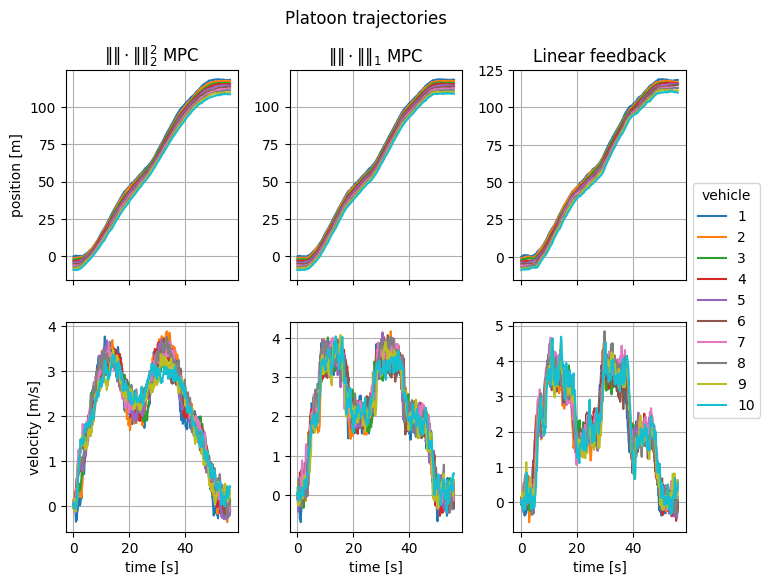

In [21]:
# let's look at plots from one of the trials
plot_i = 0

fig, ax = plt.subplots(2, 3, sharex='col', figsize=(8, 6))
fig.suptitle('Platoon trajectories')
fig.subplots_adjust(wspace=.3)
ax[0,0].set_title(rf'$\|\|\cdot\|\|_2^2$ MPC')
ax[0,1].set_title(rf'$\|\|\cdot\|\|_1$ MPC')
ax[0,2].set_title("Linear feedback")

for i in np.linspace(1, N, min(N, 10)).round().astype(int):
    ax[0,0].plot(t_range_mpc, quad_pfmpc_x_trajs[plot_i][i][0, :], label=f'{i}')
    ax[0,1].plot(t_range_mpc, l1_pfmpc_x_trajs[plot_i][i][0, :], label=f'{i}')
    ax[0,2].plot(t_range_mpc, lfbk_x_trajs[plot_i][i][0, :], label=f'{i}')

    ax[1,0].plot(t_range_mpc, quad_pfmpc_x_trajs[plot_i][i][1, :], label=f'{i}')
    ax[1,1].plot(t_range_mpc, l1_pfmpc_x_trajs[plot_i][i][1, :], label=f'{i}')
    ax[1,2].plot(t_range_mpc, lfbk_x_trajs[plot_i][i][1, :], label=f'{i}')

ax[0,0].set_ylabel('position [m]')
ax[1,0].set_ylabel('velocity [m/s]')
ax[1,0].set_xlabel('time [s]')
ax[1,1].set_xlabel('time [s]')
ax[1,2].set_xlabel('time [s]')

for a in ax.flat:
    a.grid()
    a.tick_params(axis='both')
ax[0,2].legend(bbox_to_anchor=(1.0, -0.1), loc="center left", title="vehicle");

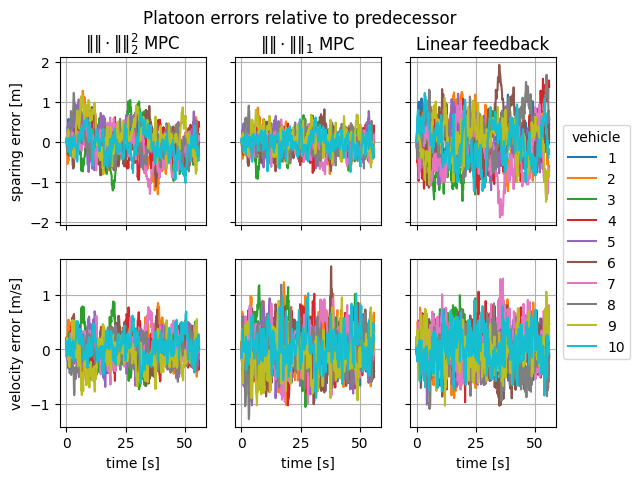

In [25]:
plot_i = 0

fig, ax = plt.subplots(2, 3, sharex='col', sharey='row')
fig.suptitle('Platoon errors relative to predecessor')
ax[0,0].set_title(rf'$\|\|\cdot\|\|_2^2$ MPC')
ax[0,1].set_title(rf'$\|\|\cdot\|\|_1$ MPC')
ax[0,2].set_title("Linear feedback")

for i in np.linspace(1, N, min(N, 10)).round().astype(int):
    ax[0,0].plot(t_range_mpc, quad_pfmpc_dist_errors[i][plot_i], label=f'{i}')
    ax[0,1].plot(t_range_mpc, l1_pfmpc_dist_errors[i][plot_i], label=f'{i}')
    ax[0,2].plot(t_range_mpc, lfbk_dist_errors[i][plot_i], label=f'{i}')

    ax[1,0].plot(t_range_mpc, quad_pfmpc_vel_errors[i][plot_i], label=f'{i}')
    ax[1,1].plot(t_range_mpc, l1_pfmpc_vel_errors[i][plot_i], label=f'{i}')
    ax[1,2].plot(t_range_mpc, lfbk_vel_errors[i][plot_i], label=f'{i}')

ax[0,0].set_ylabel('sparing error [m]')
ax[1,0].set_ylabel('velocity error [m/s]')
ax[1,0].set_xlabel('time [s]')
ax[1,1].set_xlabel('time [s]')
ax[1,2].set_xlabel('time [s]')

for a in ax.flat:
    a.grid()
    a.tick_params(axis='both')
ax[0,2].legend(bbox_to_anchor=(1.0, -0.1), loc="center left", title="vehicle");

In [26]:
# get RMS mean/stds for each vehicle
quad_pfmpc_dist_rms_means = []
quad_pfmpc_dist_rms_stds = []
quad_pfmpc_vel_rms_means = []
quad_pfmpc_vel_rms_stds = []
l1_pfmpc_dist_rms_means = []
l1_pfmpc_dist_rms_stds = []
l1_pfmpc_vel_rms_means = []
l1_pfmpc_vel_rms_stds = []
lfbk_dist_rms_means = []
lfbk_dist_rms_stds = []
lfbk_vel_rms_means = []
lfbk_vel_rms_stds = []

for i in range(2, N+1):
    quad_means = [np.sqrt(np.mean(np.square(quad_pfmpc_dist_errors[i][j]))) for j in range(n_trials)]
    quad_pfmpc_dist_rms_means.append(np.mean(quad_means))
    quad_pfmpc_dist_rms_stds.append(np.std(quad_means))
    quad_means = [np.sqrt(np.mean(np.square(quad_pfmpc_vel_errors[i][j]))) for j in range(n_trials)]
    quad_pfmpc_vel_rms_means.append(np.mean(quad_means))
    quad_pfmpc_vel_rms_stds.append(np.std(quad_means))

    l1_means = [np.sqrt(np.mean(np.square(l1_pfmpc_dist_errors[i][j]))) for j in range(n_trials)]
    l1_pfmpc_dist_rms_means.append(np.mean(l1_means))
    l1_pfmpc_dist_rms_stds.append(np.std(l1_means))
    l1_means = [np.sqrt(np.mean(np.square(l1_pfmpc_vel_errors[i][j]))) for j in range(n_trials)]
    l1_pfmpc_vel_rms_means.append(np.mean(l1_means))
    l1_pfmpc_vel_rms_stds.append(np.std(l1_means))

    lfbk_means = [np.sqrt(np.mean(np.square(lfbk_dist_errors[i][j]))) for j in range(n_trials)]
    lfbk_dist_rms_means.append(np.mean(lfbk_means))
    lfbk_dist_rms_stds.append(np.std(lfbk_means))
    lfbk_means = [np.sqrt(np.mean(np.square(lfbk_vel_errors[i][j]))) for j in range(n_trials)]
    lfbk_vel_rms_means.append(np.mean(lfbk_means))
    lfbk_vel_rms_stds.append(np.std(lfbk_means))

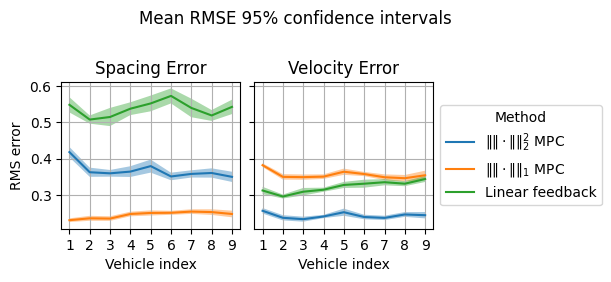

In [28]:
veh_inds = range(1, N)
fig, ax = plt.subplots(1, 2, sharey='row', figsize=(6, 3))
fig.subplots_adjust(.11, .25, .73, .74, .08, .1)
fig.suptitle('Mean RMSE 95% confidence intervals')
ax[0].set_title("Spacing Error")
ax[1].set_title("Velocity Error")

ax[0].plot(veh_inds, quad_pfmpc_dist_rms_means, color="C{}".format(0), label=r'$\|\|\cdot\|\|_2^2$ MPC')
ax[0].fill_between(veh_inds, quad_pfmpc_dist_rms_means - quad_pfmpc_dist_rms_stds/np.sqrt(10),
                    quad_pfmpc_dist_rms_means + quad_pfmpc_dist_rms_stds/np.sqrt(10), alpha=0.4)
ax[1].plot(veh_inds, quad_pfmpc_vel_rms_means, color="C{}".format(0), label=r'$\|\|\cdot\|\|_2^2$ MPC')
ax[1].fill_between(veh_inds, quad_pfmpc_vel_rms_means - quad_pfmpc_vel_rms_stds/np.sqrt(10),
                    quad_pfmpc_vel_rms_means + quad_pfmpc_vel_rms_stds/np.sqrt(10), alpha=0.4)

ax[0].plot(veh_inds, l1_pfmpc_dist_rms_means, color="C{}".format(1), label=r'$\|\|\cdot\|\|_1$ MPC')
ax[0].fill_between(veh_inds, l1_pfmpc_dist_rms_means - l1_pfmpc_dist_rms_stds/np.sqrt(10),
                    l1_pfmpc_dist_rms_means + l1_pfmpc_dist_rms_stds/np.sqrt(10), alpha=0.4)
ax[1].plot(veh_inds, l1_pfmpc_vel_rms_means, color="C{}".format(1), label=r'$\|\|\cdot\|\|_1$ MPC')
ax[1].fill_between(veh_inds, l1_pfmpc_vel_rms_means - l1_pfmpc_vel_rms_stds/np.sqrt(10),
                    l1_pfmpc_vel_rms_means + l1_pfmpc_vel_rms_stds/np.sqrt(10), alpha=0.4)

ax[0].plot(veh_inds, lfbk_dist_rms_means, color="C{}".format(2), label='Linear feedback')
ax[0].fill_between(veh_inds, lfbk_dist_rms_means - lfbk_dist_rms_stds/np.sqrt(10),
                    lfbk_dist_rms_means + lfbk_dist_rms_stds/np.sqrt(10), alpha=0.4)
ax[1].plot(veh_inds, lfbk_vel_rms_means, color="C{}".format(2), label='Linear feedback')
ax[1].fill_between(veh_inds, lfbk_vel_rms_means - lfbk_vel_rms_stds/np.sqrt(10),
                    lfbk_vel_rms_means + lfbk_vel_rms_stds/np.sqrt(10), alpha=0.4)

ax[1].legend(bbox_to_anchor=(1.0, 0.5), loc='center left', title='Method')

ax[0].set_ylabel('RMS error')
ax[0].set_xlabel('Vehicle index')
ax[1].set_xlabel('Vehicle index')

for a in ax:
    a.grid()
    a.set_xticks(range(1, N))
    a.tick_params(axis='both')